In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import intervaltree
import random
%matplotlib inline
import matplotlib as plt


In [2]:
bases = dict(zip("ACGT", [0,1,2,3]))
bases


{'A': 0, 'C': 1, 'G': 2, 'T': 3}

In [3]:
def get_confidence_regions(file):
    confidence_regions = intervaltree.IntervalTree()
    with open(file) as f:
        for row in f:
            row = row.strip().split()
            confidence_regions.addi(int(row[1]), int(row[2]))
            
    return confidence_regions


In [4]:
# [0,0,0,0,0,0,0,0] first 4 with bases, then if it is hetero
# homo, non-variant or complex variant
def create_tensors(variants, high_confidence_region, aln_tensor):
    
    confidence_regions = get_confidence_regions(high_confidence_region)
    Ys = {}
    
    # read the variants
    with open(variants) as variants:
        for row in variants:
            row = row.strip().split()
            tensor = dict(zip([0,0,0,0,0,0,0,0],
            ["A","C","G","T","het", "homo", "non_variant", "complex_variant"]))
            
            position = int(row[0])
            # not in confidence regions
            if len(confidence_regions.search(position)) == 0:
                continue
            
            # not a simple SNP
            elif len(row[1]) > 1 or len(row[2]) > 1:
                tensor["complex_variant"] = 1
                
            # hetero
            elif row[3] == 0:
                tensor["het"] = 1
                tensor[row[1][0]] = 0.5
                tensor[row[2][0]] = 0.5
                
            # mono
            else:
                tensor["homo"] = 1
                tensor[row[2][0]] = 1
            
            Ys[position] = tensor.values()
        
    Y_positions = sorted(Ys.keys())
    
    for index, item in enumerate(Y_positions):
        previous_item = Y_positions[index - 1]
        if abs(item - previous_item) < 12:
            Ys[item] = [0,0,0,0,0,0,0,1]
            Ys[previous_item] = [0,0,0,0,0,0,0,1]
    
    Xs = {}  

    with open(aln_tensor) as file: 
        for row in file:
            row = row.strip().split()
            position = int(row[0])
            sequence = row[1]
            
            # not in confidence regions
            if len(confidence_regions.search(position)) == 0:
                continue
            elif sequence[7] not in ["A","C","G","T"]:
                continue
            
            vec = np.reshape(np.array([float(x) for x in row[2:]]), (15,3,4))

            vec = np.transpose(vec, axes=(0,2,1))
            if sum(vec[7,:,0]) < 5:
                continue
            
            vec[:, :, 1] -= vec[:, :, 0]
            vec[:, :, 2] -= vec[:, :, 0]

            
            Xs[position] = vec
            
            if position not in Ys:
                base_vec = [0,0,0,0,0,0,0,0]
                base_vec[bases[sequence[7]]] = 1
                base_vec[6] = 1.
                Ys[position] = base_vec
    
    # shuffle them 
    positions = sorted(Xs.keys())
    random.shuffle(positions)
    
    # create the X and Y as numpy arrays
    Xarray = []
    Yarray = []
    pos_array = []
    for pos in positions:
        Xarray.append(Xs[pos])
        Yarray.append(Ys[pos])
        pos_array.append(pos)
    Xarray = np.array(Xarray)
    Yarray = np.array(Yarray)

    return Xarray, Yarray, pos_array


                
            
            

In [6]:

Xarray, Yarray, pos_array = create_tensors(
    "variantNet/wd/variants_chr21",
    "variantNet/testing_data/chr21/CHROM21_v.3.3.2_highconf_noinconsistent.bed",
    "variantNet/wd/aln_tensor_chr21")


In [7]:
Yarray

array([list([0, 0, 1, 0, 0, 0, 1.0, 0]),
       dict_values(['complex_variant', 1, 1]),
       list([0, 0, 1, 0, 0, 0, 1.0, 0]), ...,
       list([0, 0, 0, 1, 0, 0, 1.0, 0]),
       dict_values(['complex_variant', 1, 1]),
       dict_values(['complex_variant', 1, 1])], dtype=object)

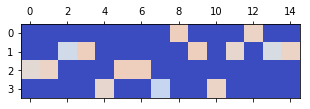

In [8]:
plt.pyplot.figure(figsize=(5, 2))
plt.pyplot.matshow(Xarray[999,:,:,0].transpose(), vmin=0, vmax=50, cmap=plt.pyplot.cm.coolwarm, fignum=0)


In [9]:
da = Xarray[999,:,:,0].transpose().copy()
da

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  29.,   0.,   0.,
          0.,  28.,   0.,   0.],
       [  0.,   0.,  23.,  29.,   0.,   0.,   0.,   0.,   0.,  29.,   0.,
         27.,   0.,  24.,  28.],
       [ 26.,  28.,   0.,   0.,   0.,  29.,  29.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,  27.,   0.,   0.,  21.,   0.,   0.,  28.,
          0.,   0.,   0.,   0.]])

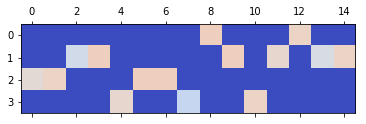

In [10]:
plt.pyplot.matshow(da, vmin=0, vmax=50, cmap=plt.pyplot.cm.coolwarm, fignum=0)


In [11]:
da[0][0] = 100
da

array([[ 100.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,   29.,
           0.,    0.,    0.,   28.,    0.,    0.],
       [   0.,    0.,   23.,   29.,    0.,    0.,    0.,    0.,    0.,
          29.,    0.,   27.,    0.,   24.,   28.],
       [  26.,   28.,    0.,    0.,    0.,   29.,   29.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,   27.,    0.,    0.,   21.,    0.,
           0.,   28.,    0.,    0.,    0.,    0.]])

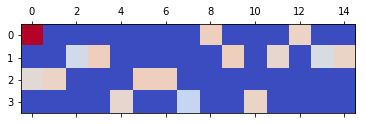

In [12]:
plt.pyplot.matshow(da, vmin=0, vmax=50, cmap=plt.pyplot.cm.coolwarm, fignum=0)


In [13]:
Xarray[998,:,:,0].transpose()

array([[ 80.,  81.,   0.,  79.,   0.,   0.,   0.,   0.,  79.,   0.,   0.,
          0.,   0.,   0.,  79.],
       [  0.,   0.,  79.,   0.,   0.,   0.,  82.,   0.,   0.,   0.,   0.,
         80.,   0.,  79.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  78.,
          0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,  76.,  81.,   0.,  73.,   0.,  79.,   0.,
          0.,  78.,   0.,   0.]])

In [14]:
Xarray[998,:,:,1].transpose()

array([[ -3.,   0.,   2.,  -3.,   0.,   1.,   1.,   4.,  -8.,   1.,   0.,
          1.,   0.,   2.,  -4.],
       [  3.,   0.,  -5.,   1.,   0.,   2.,  -2.,  36.,   4.,   0.,   0.,
         -3.,   1.,  -3.,   2.],
       [  0.,   0.,   1.,   1.,   0.,   0.,   0.,   3.,   0.,   0.,  -3.,
          1.,   2.,   0.,   1.],
       [  0.,   0.,   2.,   1.,   0.,  -3.,   1., -43.,   4.,  -1.,   3.,
          1.,  -3.,   1.,   1.]])

In [15]:
Xarray[998,:,:,2].transpose()

array([[ -3.,   0.,   2.,  -3.,   0.,   1.,   1.,   4.,  -8.,   1.,   0.,
          1.,   0.,   2.,  -4.],
       [  3.,   0.,  -5.,   1.,   0.,   2.,  -2.,  36.,   4.,   0.,   0.,
         -3.,   1.,  -3.,   2.],
       [  0.,   0.,   1.,   1.,   0.,   0.,   0.,   3.,   0.,   0.,  -3.,
          1.,   2.,   0.,   1.],
       [  0.,   0.,   2.,   1.,   0.,  -3.,   1., -43.,   4.,  -1.,   3.,
          1.,  -3.,   1.,   1.]])

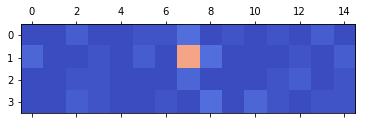

In [16]:
plt.pyplot.matshow(Xarray[998,:,:,2].transpose(), vmin=0, vmax=50, cmap=plt.pyplot.cm.coolwarm, fignum=0)


In [17]:
layer_1_nodes = 50
layer_2_nodes = 100
layer_3_nodes = 50
RUN_NAME = "run 1 with 50 nodes"
learning_rate = 0.001
training_epochs = 100
number_of_inputs = (15, 4, 3)
number_of_outputs = (4, 4)

In [28]:
tf.reset_default_graph()

with tf.variable_scope('input'):
    X = tf.placeholder(tf.float32, shape=(None,
                                          number_of_inputs[0],
                                          number_of_inputs[1],
                                          number_of_inputs[2],
                                          ), name="X")

# Layer 1
with tf.variable_scope('layer_1'):
    weights = tf.get_variable("weights1", shape=[layer_1_nodes, number_of_inputs[0],
                                          number_of_inputs[2],
                                          number_of_inputs[1]], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases1", shape=[layer_1_nodes], initializer=tf.zeros_initializer())
    layer_1_output = tf.nn.relu(tf.matmul(X, weights) + biases)

# Layer 2
with tf.variable_scope('layer_2'):
    weights = tf.get_variable("weights2", shape=[layer_1_nodes, layer_2_nodes], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases2", shape=[layer_2_nodes], initializer=tf.zeros_initializer())
    layer_2_output = tf.nn.relu(tf.matmul(layer_1_output, weights) + biases)

# Layer 3
with tf.variable_scope('layer_3'):
    weights = tf.get_variable("weights3", shape=[layer_2_nodes, layer_3_nodes], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases3", shape=[layer_3_nodes], initializer=tf.zeros_initializer())
    layer_3_output = tf.nn.relu(tf.matmul(layer_2_output, weights) + biases)

# Output Layer
with tf.variable_scope('output'):
    weights = tf.get_variable("weights4", shape=[layer_3_nodes, number_of_outputs], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases4", shape=[number_of_outputs], initializer=tf.zeros_initializer())
    prediction = tf.matmul(layer_3_output, weights) + biases

# Section Two: Define the cost function of the neural network that will be optimized during training

with tf.variable_scope('cost'):
    Y = tf.placeholder(tf.float32, shape=(None, 1), name="Y")
    cost = tf.reduce_mean(tf.squared_difference(prediction, Y))

# Section Three: Define the optimizer function that will be run to optimize the neural network

with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Create a summary operation to log the progress of the network
with tf.variable_scope('logging'):
    tf.summary.scalar('current_cost', cost)
    summary = tf.summary.merge_all()

# Initialize a session so that we can run TensorFlow operations
with tf.Session() as session:

    # Run the global variable initializer to initialize all variables and layers of the neural network
    session.run(tf.global_variables_initializer())

    # Create log file writers to record training progress.
    # We'll store training and testing log data separately.
    training_writer = tf.summary.FileWriter("./logs/{}/training".format(RUN_NAME), session.graph)
    testing_writer = tf.summary.FileWriter("./logs/{}/testing".format(RUN_NAME), session.graph)

    # Run the optimizer over and over to train the network.
    # One epoch is one full run through the training data set.
    for epoch in range(training_epochs):

        # Feed in the training data and do one step of neural network training
        session.run(optimizer, feed_dict={X: Xarray, Y: Yarray})

        # Every few training steps, log our progress
        if epoch % 5 == 0:
            # Get the current accuracy scores by running the "cost" operation on the training and test data sets
            training_cost, training_summary = session.run([cost, summary], feed_dict={X: X_scaled_training, Y:Y_scaled_training})
            testing_cost, testing_summary = session.run([cost, summary], feed_dict={X: X_scaled_testing, Y:Y_scaled_testing})

            # Write the current training status to the log files (Which we can view with TensorBoard)
            training_writer.add_summary(training_summary, epoch)
            testing_writer.add_summary(testing_summary, epoch)

            # Print the current training status to the screen
            print("Epoch: {} - Training Cost: {}  Testing Cost: {}".format(epoch, training_cost, testing_cost))


ValueError: Dimensions must be equal, but are 4 and 50 for 'layer_1/add' (op: 'Add') with input shapes: [50,15,4,4], [50].

In [38]:
a = tf.placeholder(tf.float32,shape=(None, 15, 4, 3), name="XX")
b = tf.Variable(tf.random_normal(shape=(50, 15, 3, 4)))
Aarray = tf.Variable(tf.random_normal(shape=(30, 15, 4, 3)))

In [37]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print(session.run(tf.matmul(a,b), feed_dict={X: Aarray}))


ValueError: setting an array element with a sequence.